# Code to Demonstrate Bounce

Since we are not providing the full dataset, this notebook shows how we: 
1. Pre-train the DQN agent 
2. Train Contrastive HoareLSTM to grade.

In [7]:
import json
from tqdm import tqdm

import numpy as np

import matplotlib
import matplotlib.pyplot as plt

In [2]:
from bounce.training import train_naive_hoare_lstm_model_inner
from bounce.rl_training import collect_trajs, train_collaborative_dqn, train_dqn, evaluate_agent

from bounce.agents import Agent
from bounce.bounce import BounceEnv, BALL_IN_GOAL, BALL_MISS_PADDLE, BALL_HIT_WALL, BALL_HIT_PADDLE

from bounce.bounce import Program, SELF_MINUS_HALF_OPPO

from bounce.classifiers import HoareLSTM, save_torch_model, load_torch_model

import torch.optim as optim

from bounce.featurizer import contrastive_hoarelstm_featurize

pygame 2.0.1 (SDL 2.0.14, Python 3.8.5)
Hello from the pygame community. https://www.pygame.org/contribute.html


## Pre-train DQN Agent

We first use the game's internal reward to train a DQN agent

100%|██████████| 1200/1200 [01:37<00:00,  6.35it/s, reward=25.2]

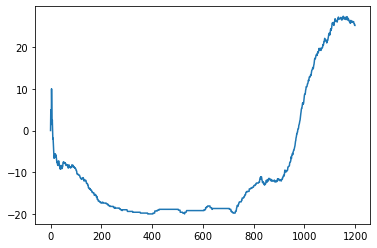

100%|██████████| 1200/1200 [01:37<00:00, 12.27it/s, reward=25.2]


In [3]:
program = Program()
program.set_correct()
env = BounceEnv(program, SELF_MINUS_HALF_OPPO, num_balls_to_win=2)

agent = Agent(env.state_size, 3, 1234, fc1_units=256, fc2_units=256)

scores, actions = train_dqn(agent, env, n_episodes=1200, eps_start=1.0, eps_end=0.01, 
                   eps_decay=0.995, max_t=200, cuda=True)

plt.plot(scores)

## Train Contrastive HoareLSTM Classifiers

The training fully works -- we just can't evaluate without the true data.

In [8]:
def fix_single_quote_in_json(json_str, fix_json=True):
    if not fix_json:
        return json_str
    
    partial_fix = json_str.replace("'", '"')
    for a in ["\"random\"", "\"very slow\"", "\"slow\"", "\"normal\"", "\"fast\"", "\"very fast\"",
             '"hardcourt"', '"retro"']:
        b = a.replace('"', "'")
        partial_fix = partial_fix.replace(a, b)
        
    return partial_fix

In [4]:
import os
from os.path import join as pjoin

def train_hoarelstm_classifiers(agent, bug_program_path, model_name, save_folder_name, max_t=100,
                               epochs=150):
    
    os.makedirs(save_folder_name, exist_ok=True)
    
    program = Program()
    program.load(bug_program_path)
    bug_env = BounceEnv(program, SELF_MINUS_HALF_OPPO, num_balls_to_win=2, info_bug=BALL_IN_GOAL)

    program = Program()
    program.set_correct()
    env = BounceEnv(program, SELF_MINUS_HALF_OPPO, num_balls_to_win=2)
    
    action_input = True
    delta = True
    cuda = True
    batch_size = 128

    lstm = HoareLSTM(15, batch_size=batch_size, delta=delta,
                     action_input=action_input)
    if cuda:
        lstm = lstm.to('cuda')
    optimizer = optim.Adam(lstm.parameters(), lr=1e-3)

    bug_lstm = HoareLSTM(15, batch_size=batch_size, delta=delta, action_input=action_input)
    if cuda:
        bug_lstm = bug_lstm.to('cuda')
    bug_optimizer = optim.Adam(bug_lstm.parameters(), lr=1e-3)

    test_accu, bug_precision, bug_recall, info = train_naive_hoare_lstm_model_inner(agent, lstm, bug_lstm, optimizer, bug_optimizer, env, bug_env, 
                                                                                 epochs=epochs,
                                                                                 cuda=cuda, 
                                                                                 action_input=action_input, 
                                                                                 eps=0.05,
                                                                                 correct_training_epoch=5, 
                                                                                 broken_training_epochs=5,
                                                                                 hoare_threshold=1.5,
                                                                                 max_t=max_t)
    
    save_torch_model(lstm, pjoin(save_folder_name, model_name + "_lstm.pkl"))
    save_torch_model(bug_lstm, pjoin(save_folder_name, model_name + "_bug_lstm.pkl"))
    agent.save(pjoin(save_folder_name, model_name + "_refined_agent.pkl"))

We load in 10 reference **bug programs** and train a contrastive HoareLSTM classifier on them.

In [ ]:
for bug_program_name in os.listdir("./bounce/programs/"):
    train_hoarelstm_classifiers(agent, './bounce/programs/'+bug_program_name, 
                            bug_program_name.rstrip(".json"), './bounce_models/goal_agent_contrast_hoarelstm/',
                            max_t=100, epochs=150)

We build a grader using simple decision rules -- each of the 10 classifiers can vote, both in terms of **state prediction distance** AND **reward distance**. In the end, we tally the vote and decide who wins.

In [5]:
def simple_hand_made_classifier(x, tie_breaker=True, vote_against_correct=3):
    
    # if any 1 condition is violated, then it's wrong
    # The logic here is:
    # 1. if dist_correct and dist_broken are similar (within 10 diff), call it broken
    # 2. otherwise, go with the closer one (smaller one)
    # 3. if reward_to_correct and reward_to_broken are similar (within 5 diff), call it correct (WHY???)
    # 4. otherwise, go with the closer one (smaller one)
    
    # we make it a voting system
    # each criteria has one vote, and let's see who wins
    
    decision = [0, 0]
    
    for i in range(0, x.shape[0], 5):
        if np.abs(x[i+1] - x[i+0]) <= 10:
            vote = 1  # call it broken (this is because for contrastive hoareLSTM, when it's close to neither, it's a new form of wrong)
            decision[vote] += 1
        elif np.abs(x[i+1] - x[i+0]) > 10:
            vote = np.argmin([x[i+0], x[i+1]])
            decision[int(vote)] += 1

        if np.abs(x[i+3] - x[i+2]) <= 1:
            pass  # doesn't mean anything, no decision
        else:
            vote = np.argmin([x[i+2], x[i+3]])
            decision[int(vote)] += 1
    
    # tie-breaker
    if decision[0] == decision[1]:
        decision[1] += 1
        
    # since it's comparing against 10 MDPs, it shouldn't be majority voting
    if decision[0] - decision[1] > vote_against_correct:
        decision = [1, 0]
    else:
        decision = [0, 1]
        
    return decision

class HandClassifierModel(object):
    def __init__(self, tie_breaker=True):
        self.tie_breaker = tie_breaker
    
    def predict(self, X):
        new_y_hat = []
        for i in range(X.shape[0]):
            new_y_hat.append(np.argmax(simple_hand_made_classifier(X[i], tie_breaker=self.tie_breaker)))
            
        return new_y_hat

In [ ]:
def featurize(save_folder_name, bug_program_path, test_env, K=10, max_t=200, total_reward_feat=True):
    
    X = []
    for bug_program_name in os.listdir("./bounce/programs/"):
        model_name = bug_program_name.rstrip(".json")
        
        action_input = True
        delta = True
        cuda = True
        batch_size = 128

        lstm = HoareLSTM(15, batch_size=batch_size, delta=delta,
                         action_input=action_input)
        if cuda:
            lstm = lstm.to('cuda')

        bug_lstm = HoareLSTM(15, batch_size=batch_size, delta=delta, action_input=action_input)
        if cuda:
            bug_lstm = bug_lstm.to('cuda')
            
        agent = Agent(15, 3, 1234, fc1_units=256, fc2_units=256)

        load_torch_model(lstm, pjoin(save_folder_name, model_name + "_lstm.pkl"))
        load_torch_model(bug_lstm, pjoin(save_folder_name, model_name + "_bug_lstm.pkl"))
        agent.load(pjoin(save_folder_name, model_name + "_refined_agent.pkl"))
        
        _, _, traj_orig_rewards, correct_state_dists, broken_state_dists,  \
        correct_reward_dists, broken_reward_dists = contrastive_hoarelstm_featurize(agent, test_env, lstm, bug_lstm, 
                                                                            n_episodes=K, 
                                                                            max_t=max_t,
                                                                           cuda=cuda, action_input=action_input)
        
        # (K, 5)
        if total_reward_feat:
            X_feats = np.vstack([correct_state_dists, broken_state_dists, \
                               correct_reward_dists, broken_reward_dists, traj_orig_rewards]).T
        else:
            X_feats = np.vstack([correct_state_dists, broken_state_dists, \
                               correct_reward_dists, broken_reward_dists]).T
        X.append(X_feats)
        
    X = np.hstack(X)
    
    return X

In [6]:
from sklearn.metrics import accuracy_score, classification_report

def grade(model, correct_json_path, broken_json_path, K=1, grade_all=False, grade_first=100,
         fix_json=True):
    # collect stats
    correct_jsons = json.load(open(correct_json_path))
    broken_jsons = json.load(open(broken_json_path))
    if not grade_all:
        correct_jsons = correct_jsons[:grade_first]
        broken_jsons = broken_jsons[:grade_first]
    
    X, y = [], []
    for correct_json in tqdm(correct_jsons):
        program = Program()
        program.loads(fix_single_quote_in_json(correct_json, fix_json=fix_json))
        env = BounceEnv(program, SELF_MINUS_HALF_OPPO, num_balls_to_win=2, info_bug=BALL_IN_GOAL)
        
        correct_X = featurize('./bounce_models/goal_agent_contrast_hoarelstm/', './bounce/programs/',
                             env, K=1)
        X.append(correct_X)
        y.append(0)
        
    
    for broken_json in tqdm(broken_jsons):
        program = Program()
        program.loads(fix_single_quote_in_json(broken_json, fix_json=fix_json))
        env = BounceEnv(program, SELF_MINUS_HALF_OPPO, num_balls_to_win=2, info_bug=BALL_IN_GOAL)
        
        correct_X = featurize('./bounce_models/goal_agent_contrast_hoarelstm/', './bounce/programs/',
                             env, K=1)
        X.append(correct_X)
        y.append(1)
        
    X = np.vstack(X)
    y_hat = model.predict(X)
    y = np.array(y)
    
    print(classification_report(y, y_hat))
    
    return X, y, y_hat

This code is not runnable -- but we load in the test data and grade them.

In [ ]:
path = "./bounce/programs/"
X, y, y_hat = grade(HandClassifierModel(), path+"body_sampled_correct_250.json", 
                    path+"body_sampled_broken_250.json", grade_all=True, fix_json=False)